In [8]:
import os, sys
import Holes as ho
import networkx as nx
import pandas as pd
import cPickle as pk
import matplotlib.pyplot as plt
import numpy as np

In [9]:
%matplotlib inline

In [10]:
import scipy
from scipy import linalg, matrix
def null(A, eps=1e-12):
    u, s, vh = scipy.linalg.svd(A)
    null_mask = (s <= eps)
    null_space = scipy.compress(null_mask, vh, axis=0)
    return scipy.transpose(null_space)

Given a matrix (that in our case will be the combinatorial Laplacian of a filtration), find the nullspace basis:

In [11]:
import Laplacian_toolkit as tl

In [12]:
g = nx.grid_2d_graph(4,4,periodic=False);
edge_weights = {}
relabel = {}

for i,n in enumerate(g.nodes()):
    relabel[n] = i;
    
g = nx.relabel_nodes(g,relabel)
print g.nodes()
for n in g.edges():
    if len(g.neighbors(n[0]))<=3 and len(g.neighbors(n[1]))<=3 :
        edge_weights[(n[0],n[1])] = 2;
    else:
        edge_weights[(n[0],n[1])] = 1;

print edge_weights
nx.set_edge_attributes(g,'weight',edge_weights)
fil = ho.filtrations.standard_weight_clique_rank_filtration(g)
inv_fil=tl.invert_filtration_dictionary(fil)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
{(5, 9): 2, (10, 11): 2, (5, 6): 2, (1, 15): 1, (2, 12): 1, (0, 3): 2, (8, 14): 2, (6, 7): 1, (7, 15): 1, (0, 15): 1, (7, 12): 1, (1, 10): 1, (2, 6): 2, (3, 13): 2, (13, 15): 1, (0, 8): 2, (11, 12): 1, (4, 11): 2, (7, 9): 1, (9, 13): 2, (1, 12): 1, (1, 8): 1, (10, 14): 2, (2, 4): 2}
Preliminary scan of edge weights to define filtration steps...
Constructing filtration...
Max filtration value: 1
Clique dictionary created.


In [13]:
inv_fil

{(0, 1): [{13}, {8}, {11}, {6}, {4}, {2}, {0}, {14}, {9}, {10}, {5}, {3}],
 (0, 2): [{0, 8},
  {10, 14},
  {5, 9},
  {4, 11},
  {0, 3},
  {3, 13},
  {9, 13},
  {8, 14},
  {5, 6},
  {2, 6},
  {2, 4},
  {10, 11}],
 (1, 1): [{15}, {7}, {12}, {1}],
 (1, 2): [{2, 12},
  {13, 15},
  {1, 15},
  {7, 9},
  {11, 12},
  {0, 15},
  {1, 8},
  {1, 10},
  {1, 12},
  {7, 12},
  {7, 15},
  {6, 7}]}

/usr/local/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/usr/local/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


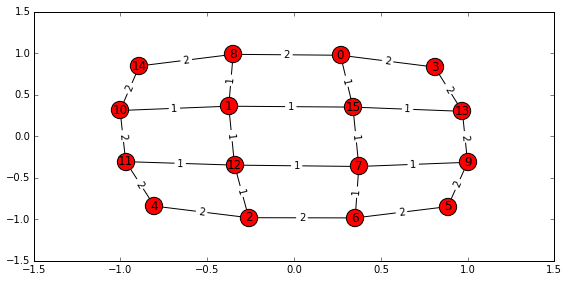

In [14]:
def draw_weighted_labeled_network(G,title='',pos=None):
    fig = plt.figure(figsize=(8,4))
    if pos==None:
        pos = nx.spectral_layout(G)
    nx.draw_networkx_nodes(G,pos=pos);
    nx.draw_networkx_labels(G,pos=pos);
    nx.draw_networkx_edges(G,pos=pos);
    nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'weight'))
    plt.title(title);
    plt.tight_layout()
    plt.show()

pos = nx.spring_layout(g)
draw_weighted_labeled_network(g,pos=pos)

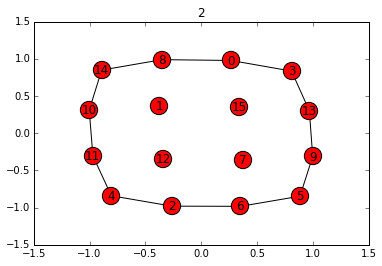

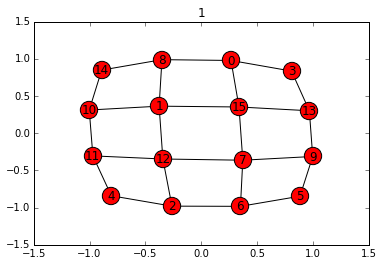

In [15]:
wd = nx.get_edge_attributes(g,'weight');
edge_weights=sorted(list(set(nx.get_edge_attributes(g,'weight').values())),reverse=True)
for w in edge_weights:
    auxiliary_g = g.copy()
    for edge in wd:
        if wd[edge]<w:
            auxiliary_g.remove_edge(edge[0],edge[1])
    nx.draw_networkx(auxiliary_g,pos=pos);
    plt.title(str(w))
    plt.show()

In [16]:
g.number_of_edges(), nx.complete_graph(g.number_of_nodes()).number_of_edges()

(24, 120)

In [17]:
original_weights=sorted(list(set(nx.get_edge_attributes(g,'weight').values())),reverse=True)

In [18]:
simplex_ordered_base={}
dimensions=list(set(map(lambda x: x[1], inv_fil.keys())))
for d in sorted(dimensions):
    simplex_ordered_base[d]=[]
    for key in sorted(inv_fil.keys()):
        if key[1]==d:
            simplex_ordered_base[d].extend(map(list,inv_fil[key]))

relabeled_simplex_ordered_base={}
for d in dimensions:
    relabeled_simplex_ordered_base[d]={}
    for i,el in enumerate(simplex_ordered_base[d]):
        relabeled_simplex_ordered_base[d][str(el)]=i;

In [19]:
k=1
Laplacian_dict={}
Laplacian_dict[0],D1C,D2C,O1C,O2C=tl.Laplacian(inv_fil,0,k)
for c in range(1,len(inv_fil)):
    print c 
    Laplacian_dict[c],D1C,D2C,O1C,O2C=tl.Laplacian(inv_fil,c,k,D1C,O1C,D2C,O2C)
    

(0, 1)
(0, 2)
1
(1, 1)
(1, 2)
2
no new 0 simplex
(2, 1)
no new 1 simplex
(2, 2)
3
no new 0 simplex
(3, 1)
no new 1 simplex
(3, 2)


In [20]:
def gs(X, row_vecs=False, norm = True):
    if not row_vecs:
        X = X.T
    Y = X[0:1,:].copy()
    for i in range(1, X.shape[0]):
        proj = np.diag((X[i,:].dot(Y.T)/np.linalg.norm(Y,axis=1)**2).flat).dot(Y)
        Y = np.vstack((Y, X[i,:] - proj.sum(0)))
    if norm:
        Y = np.diag(1/np.linalg.norm(Y,axis=1)).dot(Y)
    if row_vecs:
        return Y
    else:
        return Y.T


In [21]:
nullspaces={}
import time
for l,e in enumerate(sorted(Laplacian_dict.keys())):
    if l>=1:
        
        now=time.time()
        L=Laplacian_dict[e];
        L_old=Laplacian_dict[Laplacian_dict.keys()[l-1]];

        if (L.shape==L_old.shape):#  and (L==L_old).all(): unnecessary condition
            nullspaces[e] = nullspaces[Laplacian_dict.keys()[l-1]]
        else:
            nA=null(Laplacian_dict[e])
            nullspaces[e] = gs(nA);
            
    else:
        now=time.time()
        nA=null(Laplacian_dict[e])
        nullspaces[e]=gs(nA);
        
    print e, Laplacian_dict[e].shape, nA.shape, time.time()-now

0 (12, 12) (12, 1) 0.000581979751587
1 (24, 24) (24, 9) 0.00159311294556
2 (24, 24) (24, 9) 4.6968460083e-05
3 (24, 24) (24, 9) 4.6968460083e-05


# Optimization attempt

In [22]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution

def IPR(v,p=4,verbose=False):
    n=float(np.linalg.norm(v))
    if n>0:
        if n!=1.0:
            if verbose==True:
                print 'Input vector with norm', n
            v=v/n
        return np.sum(map(lambda x: x**p,v));
    else:
        return IPR(np.ones(len(v)))


def kernel_base_IPR(x,nA):
    """
    the function expects as an input a vector with length equal to the 
    dimension of the kernel
    """
    return IPR(np.dot(nA,np.transpose(x)))

   
def orthogonality_bit(x,nA,new_base_matrix_list,mode='max'):
    s=[];
    for l in range(new_base_matrix_list.shape[1]):
        if np.linalg.norm(new_base_matrix_list[:,l])>0:
            s.append(np.dot(np.dot(nA,np.transpose(x))/np.linalg.norm(np.dot(nA,np.transpose(x))) , new_base_matrix_list[:,l]/np.linalg.norm(new_base_matrix_list[:,l])));
        else:
            s.append(0);
    if mode=='max':
        z = np.max(map(lambda x: x**2,s))
    if mode=='mean':
        z = np.mean(map(lambda x: x**2,s))
    return z

def find_optimal_base(nA,alpha,max_attempts=1,verbose=False):
    import copy
    attempt=0;
    if verbose==True:
        print 'Dimensions of null space', nA.shape
    base_matrix_list = nA   
    while attempt<max_attempts:
        attempt+=1;
        new_base_matrix_list=np.zeros_like(base_matrix_list);
        if verbose==True:
            print 'attempt', attempt
        #run over the kernel vectors 
        for k in range(nA.shape[1]):
            print 'Starting optimisation of vector ', k
            x0 = []
            for i in range(nA.shape[1]):
                x0.append([-1,1])#[np.random.random(nA.shape[1])];
            x0=np.array(x0)
            inner_new_base_matrix_list=new_base_matrix_list[:,:k];
            def single_snapshot_trades(x):
                if inner_new_base_matrix_list.shape[1]>=1:
                    t = -alpha*kernel_base_IPR(x,nA) ## maximal IPR contributes to the minimazation 
                    r = (1-alpha)*orthogonality_bit(x,nA,inner_new_base_matrix_list);
                    return t+r
                else:
                    return -alpha*kernel_base_IPR(x,nA)
            res = differential_evolution(single_snapshot_trades, x0)#, T=0.1, niter=100,stepsize=.01)
            new_v = np.dot(nA,np.transpose(res['x']))/np.linalg.norm(np.dot(nA,np.transpose(res['x'])))
            new_base_matrix_list[:,k]=np.squeeze(new_v);

        if np.mean(map(lambda x: IPR(new_base_matrix_list[:,x]), range(new_base_matrix_list.shape[1])))>=np.mean(map(lambda x: IPR(base_matrix_list[:,x]), range(base_matrix_list.shape[1]))):
            print 'Updating base matrix with new one.'
            base_matrix_list = copy.copy(new_base_matrix_list);
            if verbose==True:
                print 'IPR report:', np.mean(map(lambda x: IPR(base_matrix_list[:,x]), range(new_base_matrix_list.shape[1]))), np.mean(map(lambda x: IPR(nA[:,x]), range(nA.shape[1])))
        else:
            print 'New base matrix is not satisfactory.'
            
    if verbose==True:
        print 'Final IPR report:', np.mean(map(lambda x: IPR(base_matrix_list[:,x]), range(new_base_matrix_list.shape[1]))), np.mean(map(lambda x: IPR(nA[:,x]), range(nA.shape[1])))


    return base_matrix_list


# Mapping of onto the actual basis

In [23]:
import copy
dimensions=list(set(map(lambda x: x[1], inv_fil.keys())))
steps=sorted(list(set(map(lambda x: x[0], inv_fil.keys()))))

simplex_ordered_at_step={}
k=1

simplex_ordered_at_step[0] = list(map(list,inv_fil[(0,k+1)]));
optimal_bases={}

# initialization of the first basis, for use later
s=steps[0]
print 0,s
print 'Dimension of null space', nullspaces[s].shape
if nullspaces[s].shape[1]>1:
    optimal_bases[s] = (find_optimal_base(nullspaces[s],0.5,5,True), map(lambda x: relabeled_simplex_ordered_base[k+1][str(x)], list(simplex_ordered_at_step[s])));
elif nullspaces[s].shape[1]==1:
    optimal_bases[s] = (nullspaces[s]/np.linalg.norm(nullspaces[s]), map(lambda x: relabeled_simplex_ordered_base[k+1][str(x)], list(simplex_ordered_at_step[s])));
else:
    optimal_bases[s] = ([], map(lambda x: relabeled_simplex_ordered_base[k+1][str(x)], list(simplex_ordered_at_step[s])));

print '\n'
for i,s in enumerate(steps[1:]):
    print i,s
    simplex_ordered_at_step[s] = copy.copy(simplex_ordered_at_step[steps[i]]);
    simplex_ordered_at_step[s].extend(list(map(list,inv_fil[s,k+1])))
    now=time.time()
    if nullspaces[s].shape[1]>1:
        optimal_bases[s] = (find_optimal_base(nullspaces[s],0.5,10,True), map(lambda x: relabeled_simplex_ordered_base[k+1][str(x)], list(simplex_ordered_at_step[s])));
    else:
        if nullspaces[s].shape[1]==1:
            optimal_bases[s] = (nA/np.linalg.norm(nullspaces[s]), map(lambda x: relabeled_simplex_ordered_base[k+1][str(x)], list(simplex_ordered_at_step[s])));
        else:
            optimal_bases[s] = ([], map(lambda x: relabeled_simplex_ordered_base[k+1][str(x)], list(simplex_ordered_at_step[s])));
    print '\n'

0 0
Dimension of null space (12, 1)


0 1
Dimensions of null space (24, 9)
attempt 1
Starting optimisation of vector  0
Starting optimisation of vector  1
Starting optimisation of vector  2
Starting optimisation of vector  3
Starting optimisation of vector  4
Starting optimisation of vector  5
Starting optimisation of vector  6
Starting optimisation of vector  7
Starting optimisation of vector  8
Updating base matrix with new one.
IPR report: 0.234043654045 0.10208917363
attempt 2
Starting optimisation of vector  0
Starting optimisation of vector  1
Starting optimisation of vector  2
Starting optimisation of vector  3
Starting optimisation of vector  4
Starting optimisation of vector  5
Starting optimisation of vector  6
Starting optimisation of vector  7
Starting optimisation of vector  8
Updating base matrix with new one.
IPR report: 0.242082388381 0.10208917363
attempt 3
Starting optimisation of vector  0
Starting optimisation of vector  1
Starting optimisation of vector  2
Starting

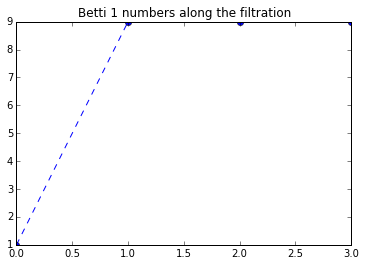

In [24]:
plt.plot(sorted(nullspaces.keys()), map(lambda x: nullspaces[x].shape[1], sorted(nullspaces.keys())),'--o')
plt.title('Betti 1 numbers along the filtration')

Note that the above should be quite easy to compute in a parallel way, since each step is performed independently   
once the filtration has been produced. 

In [25]:
indexed_bases_dict={}
for e in sorted(optimal_bases.keys()):
    if len(optimal_bases[e][0])>0:
        indexed_bases=pd.DataFrame(np.array(optimal_bases[e][0]))
        print e, pd.DataFrame(optimal_bases[e][0]).shape, len(optimal_bases[e][1])
        if indexed_bases.shape[1]>0:
            # quantum-wave-like version
            indexed_bases_dict[e]=pd.DataFrame(np.power(optimal_bases[e][0].T,2), columns=optimal_bases[e][1])
            # L1-norm-like version
            #indexed_bases_dict[e]=pd.DataFrame(np.abs(optimal_bases[e][0]), columns=optimal_bases[e][1])
    else:
        print 'I am skipping ', e
            

0 (12, 1) 12
1 (24, 9) 24


In [26]:
optimal_bases, indexed_bases_dict

({0: (array([[-0.28867513],
          [ 0.28867513],
          [-0.28867513],
          [ 0.28867513],
          [ 0.28867513],
          [ 0.28867513],
          [-0.28867513],
          [-0.28867513],
          [ 0.28867513],
          [-0.28867513],
          [ 0.28867513],
          [-0.28867513]]), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]),
  1: (array([[  1.66409954e-05,  -3.96286098e-06,   4.99999618e-01,
             2.03740748e-05,   1.11863364e-01,   1.78379648e-02,
            -4.46689835e-02,  -1.15961362e-01,   1.79115887e-02],
          [ -1.03225137e-05,   1.41117267e-07,   4.01865161e-06,
             2.44067696e-05,  -2.13315610e-02,  -8.79907001e-03,
             5.27899440e-03,   5.40178767e-01,  -2.05548267e-02],
          [ -2.78419434e-05,   1.85772886e-05,  -1.32192017e-07,
             1.02744500e-05,   2.13037235e-02,   5.38429975e-01,
             9.54138597e-03,  -7.40323533e-03,   2.05586288e-02],
          [  2.28571838e-06,  -2.17724731e-06,  -4.30265370e-07

In [27]:
laplacian_weights = {}
original_weights.append(0)
w=np.diff(original_weights[::-1])[::-1];
for i,e in enumerate(optimal_bases):
    laplacian_weights[e]=w[i]

In [28]:
laplacian_weights

{0: 1, 1: 1}

In [29]:
deformed_stepwise_vectors = pd.DataFrame(columns=indexed_bases_dict.keys(), index=(relabeled_simplex_ordered_base[2].values()));
for e in indexed_bases_dict:
    deformed_stepwise_vectors[e] = laplacian_weights[e]*indexed_bases_dict[e].sum()
deformed_stepwise_vectors.fillna(0);

In [30]:
edge_weights = deformed_stepwise_vectors.sum(axis=1)

In [31]:
def draw_kernel_eigenvector(scaffold,pos,relabeled_simplex_ordered_base,dim,kernel_eigenvector):
    g = nx.Graph();
    g.add_nodes_from(scaffold.nodes());
    g.add_edges_from(scaffold.edges());
    nx.draw_networkx(g,pos,node_color='r',node_size=300,alpha=0.8)
    nx.draw_networkx_edges(g,pos,width=1.0,alpha=0.5);    

    for edge_name in relabeled_simplex_ordered_base[dim]:
        if relabeled_simplex_ordered_base[dim][edge_name] in kernel_eigenvector.index:
            edge =list(eval(edge_name))
            w = kernel_eigenvector[relabeled_simplex_ordered_base[dim][edge_name]];
            nx.draw_networkx_edges(g,pos,edgelist=[(int(edge[0]),int(edge[1]))],width=50*w,alpha=0.5,edge_color='r')
    return

def draw_aggregated_kernel_eigenvector(scaffold,pos,relabeled_simplex_ordered_base,dim,kernel_eigenvector):
    g = nx.Graph();
    g.add_nodes_from(scaffold.nodes());
    g.add_edges_from(scaffold.edges());
    nx.draw_networkx(g,pos,node_color='r',node_size=300,alpha=0.8)
    nx.draw_networkx_edges(g,pos,width=1.0,alpha=0.5);    

    for edge_name in relabeled_simplex_ordered_base[dim]:
        edge =list(eval(edge_name))
        w = kernel_eigenvector[relabeled_simplex_ordered_base[dim][edge_name]];
        nx.draw_networkx_edges(g,pos,edgelist=[(int(edge[0]),int(edge[1]))],width=10*w,alpha=0.5,edge_color='b')
    return


In [32]:
def recreate_scaffold(edge_weights,relabeled_simplex_ordered_base,dim):
    scaffold = nx.Graph()
    scaffold.add_nodes_from(map(lambda x: int(eval(x)[0]), relabeled_simplex_ordered_base[1].keys()))
    for edge_name in relabeled_simplex_ordered_base[dim]:
        edge =list(eval(edge_name))
        scaffold.add_edge(int(edge[0]), int(edge[1]),weight=edge_weights[relabeled_simplex_ordered_base[2][edge_name]])        
#        scaffold.add_edge(relabeled_simplex_ordered_base[1][str([edge[0]])], relabeled_simplex_ordered_base[1][str([edge[1]])],weight=edge_weights[relabeled_simplex_ordered_base[2][edge_name]])
    return scaffold;
scaffold = recreate_scaffold(edge_weights, relabeled_simplex_ordered_base,2)

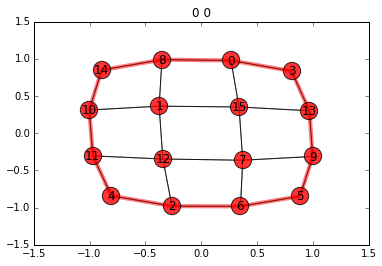

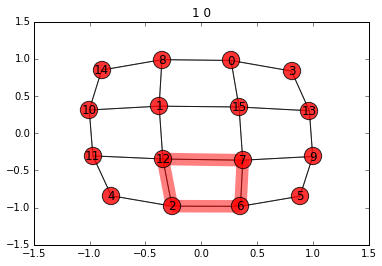

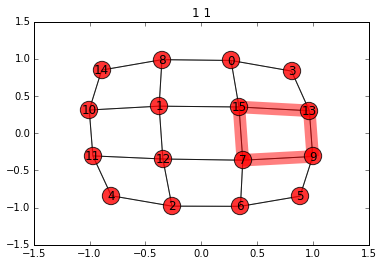

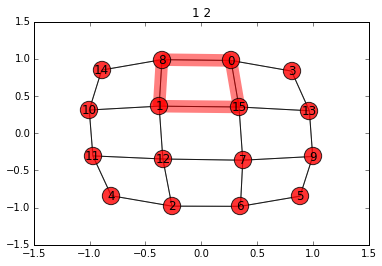

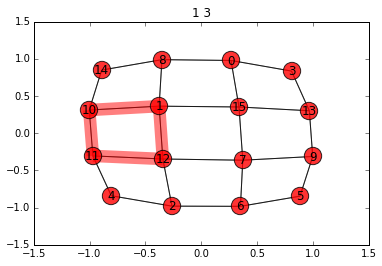

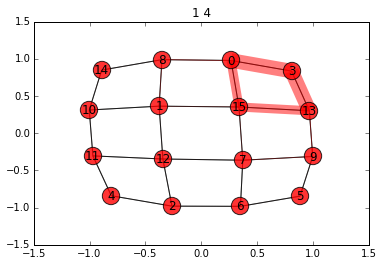

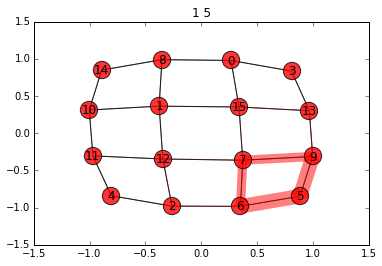

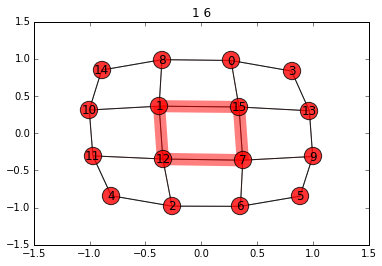

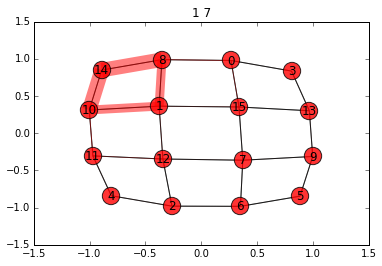

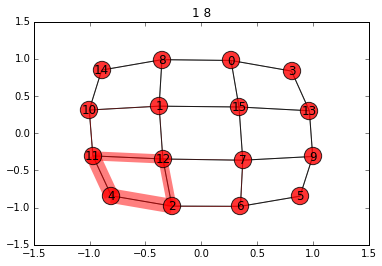

In [33]:
#pos = nx.spring_layout(scaffold);
for c in indexed_bases_dict:
    for i,el in indexed_bases_dict[c].iterrows():
        draw_kernel_eigenvector(scaffold, pos, relabeled_simplex_ordered_base,2,el)
        plt.title(str(c)+' '+str(i))
        plt.show()